In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

In [62]:
climatic_year = 1985
TY = 2030

pypsa_dir = '../results/'
PECD_dir = f'../../resources/climatic/PECD/TY{TY}/CY{climatic_year}/'
remix_dir = f'/data/ES2050/ensym/DestinE/ERAA/results_by_country_v2022/TY{TY}/CY{climatic_year}/'

In [63]:
network = pypsa.Network(pypsa_dir+f'pilot_elec-vre-hydro_simpl_TY{TY}_{climatic_year}.nc')
gen_p_pypsa = network.generators_t.p.groupby([network.generators.bus, network.generators.carrier], axis=1).sum()
gen_p_by_carrier_pypsa = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
p_max_pu_pypsa = network.generators_t.p_max_pu.groupby([network.generators.bus, network.generators.carrier], axis=1).mean()

INFO:pypsa.io:Imported network pilot_elec-vre-hydro_simpl_TY2030_1985.nc has buses, carriers, generators, links, loads, stores


In [64]:
p_max_pu_PECD = pd.read_csv(PECD_dir+'generation_vre_timeseries.csv', header=0, index_col=0)
PECD_gens = pd.DataFrame(index=p_max_pu_PECD.columns)
PECD_gens['bus'] = [c.split(' - ')[0] for c in PECD_gens.index]
PECD_gens['carrier'] = [c.split(' - ')[1] for c in PECD_gens.index]

p_max_pu_PECD = p_max_pu_PECD.groupby([PECD_gens.bus, PECD_gens.carrier], axis=1).mean()
p_max_pu_PECD.index = gen_p_pypsa.index

In [65]:
gen_p_remix = pd.read_csv(remix_dir+'dispatch.csv', header=0, index_col=0)
remix_gens = pd.DataFrame(index=gen_p_remix.columns)
remix_gens['bus'] = [c.split(' - ')[0] for c in remix_gens.index]
remix_gens['carrier'] = [c.split(' - ')[1] for c in remix_gens.index]

p_max_pu_remix = pd.read_csv(remix_dir+'cfs.csv', header=0, index_col=0)
soc_remix = pd.read_csv(remix_dir+'storage_levels.csv', header=0, index_col=0)

gen_p_by_carrier_remix = gen_p_remix.groupby(remix_gens.carrier, axis=1).sum()
gen_p_remix = gen_p_remix.groupby([remix_gens.bus, remix_gens.carrier], axis=1).sum()
p_max_pu_remix = p_max_pu_remix.groupby([remix_gens.bus, remix_gens.carrier], axis=1).mean()
gen_p_by_carrier_remix.index = gen_p_pypsa.index
gen_p_remix.index = gen_p_pypsa.index
p_max_pu_remix.index = gen_p_pypsa.index
soc_remix.index = gen_p_pypsa.index

In [66]:
disp_links = network.links.index[network.links.carrier.isin(['hydro dispatch', 'OLPHS dispatch', 'CLPHS dispatch'])]
store_links = network.links.index[network.links.carrier.isin(['hydro store', 'OLPHS store', 'CLPHS store'])]

su_p_dispatch_pypsa = network.links_t.p1[disp_links].groupby(network.links.bus0[disp_links], axis=1).sum()
su_p_store_pypsa = network.links_t.p0[store_links].groupby(network.links.bus1[store_links], axis=1).sum().reindex(columns=su_p_dispatch_pypsa.columns, fill_value=0.)
su_p_pypsa = -su_p_dispatch_pypsa - su_p_store_pypsa

In [67]:
tmp = gen_p_remix['NO']['PumpStorageOpenLoopTurbine'] - gen_p_remix['NO']['PumpStorageOpenLoopPumping']

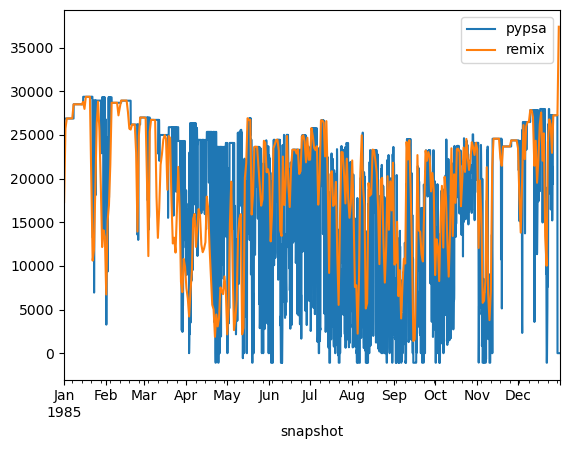

In [68]:
su_p_pypsa['NO OLPHS'].plot(label='pypsa')
tmp.resample('1D').mean().plot(label='remix')
plt.legend()

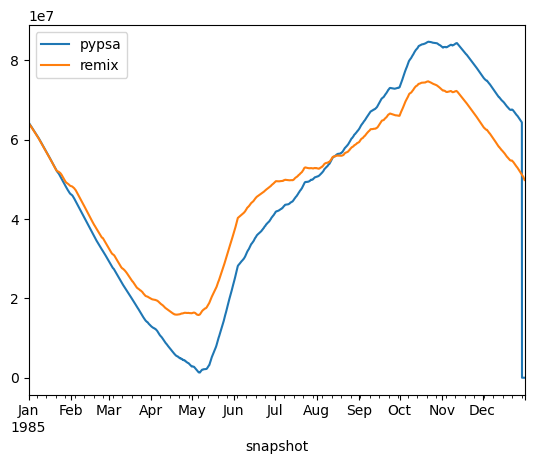

In [69]:
network.stores_t.e.groupby(network.stores.bus, axis=1).sum()['NO OLPHS'].plot(label='pypsa')
soc_remix['NO - HydroPumpStorageOpenLoop'].plot(label='remix')
plt.legend()

Text(0.5, 1.0, 'DE Onshore Wind')

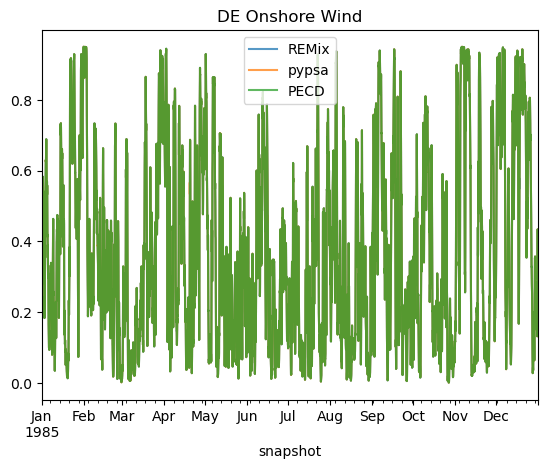

In [70]:
p_max_pu_remix['DE']['WindOnshore'].plot(label='REMix', alpha=0.75)
p_max_pu_pypsa['DE']['onwind'].plot(label='pypsa', alpha=0.75)
p_max_pu_PECD['DE00']['Wind Onshore'].plot(label='PECD', alpha=0.75)
#plt.twinx()
#network.generators_t.p_max_pu['DE onwind'].plot(c='green')
plt.legend()
plt.title('DE Onshore Wind')
#plt.xlim('2002-01-15 00:00:00', '2002-02-16 23:00:00')

Text(0.5, 1.0, 'DE Onshore Wind')

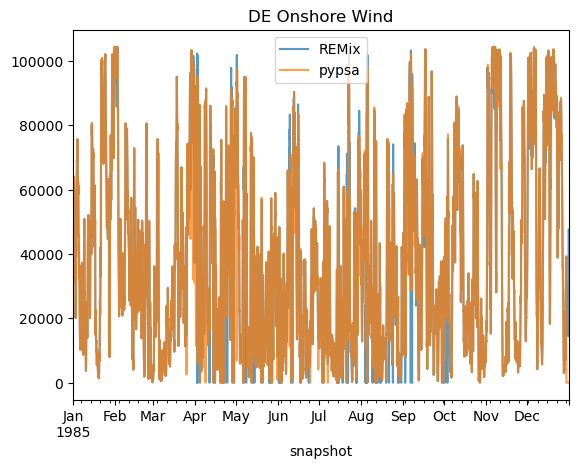

In [71]:
gen_p_remix['DE']['WindOnshore'].plot(label='REMix', alpha=0.75)
gen_p_pypsa['DE']['onwind'].plot(label='pypsa', alpha=0.75)
#plt.twinx()
#network.generators_t.p_max_pu['DE onwind'].plot(c='green')
plt.legend()
plt.title('DE Onshore Wind')
#plt.xlim('2000-05-15 00:00:00', '2000-05-16 23:00:00')

Text(0.5, 1.0, 'DE Slack')

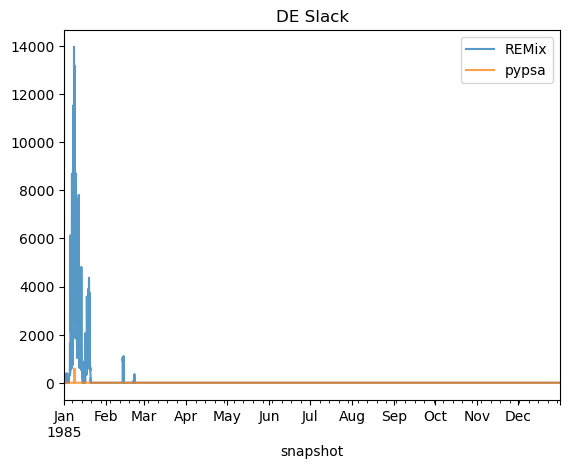

In [88]:
gen_p_remix['AT']['Slack'].plot(label='REMix', alpha=0.75)
gen_p_pypsa['AT']['Load'].plot(label='pypsa', alpha=0.75)
#plt.twinx()
#network.generators_t.p_max_pu['DE onwind'].plot(c='green')
plt.legend()
plt.title('DE Slack')
#plt.xlim('2000-05-15 00:00:00', '2000-05-16 23:00:00')

In [73]:
date_max_slack = gen_p_pypsa.groupby(axis=1, level=1).sum()['Load'].idxmax()
gen_p_pypsa.groupby(axis=1, level=1).sum().loc[date_max_slack,:].sort_values()

carrier
solar                      0.009791
oil                     5035.829284
biofuel                 5911.960946
CSP                    12626.957279
coal                   13948.203315
offwind                16053.855308
ror                    18882.783017
lignite                19263.049890
surface_runoff         34535.375320
other conventional     43120.997862
other RE               50698.713827
onwind                 66311.723744
nuclear                87259.274338
Load                  105802.770216
gas                   197241.707324
Name: 1985-01-19 18:00:00, dtype: float64

In [74]:
gen_p_remix.groupby(axis=1, level=1).sum().loc[date_max_slack,:].sort_values()

carrier
Demand                         -789909.311108
PumpStorageOpenLoopPumping       -3489.804391
PumpStorageClosedLoopPumping     -2920.697335
BatteriesOfftake                  -112.786362
SolarPhotovoltaic                    0.000000
HVDC                                 0.000001
HVAC                                 0.000001
PondageTurbine                    1629.114559
BatteriesInjection                3090.324724
Oil                               4869.738196
Biofuel                           5911.961100
SolarThermal                     12649.448511
HardCoal                         13697.759478
Lignite                          15988.273565
WindOffshore                     16049.070486
RunofRiver                       18880.755333
PumpStorageClosedLoopTurbine     26694.837702
Othersnon-renewable              43120.998954
PumpStorageOpenLoopTurbine       48506.427561
Othersrenewable                  50697.817000
WindOnshore                      66300.807231
ReservoirTurbine          

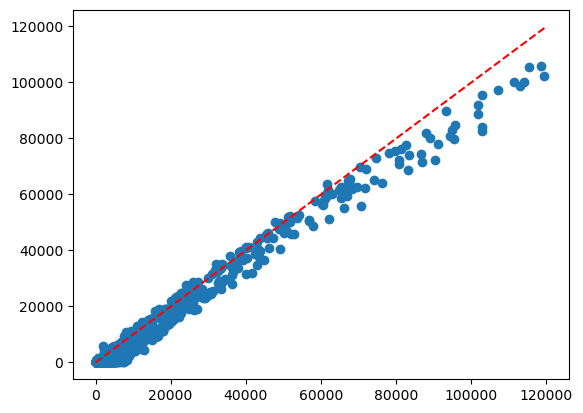

In [76]:
slack_pypsa = gen_p_pypsa.groupby(axis=1, level=1).sum()['Load']
slack_remix = gen_p_remix.groupby(axis=1, level=1).sum()['Slack']

plt.scatter(slack_remix, slack_pypsa)
plt.plot([0, 120000], [0, 120000], 'r--')

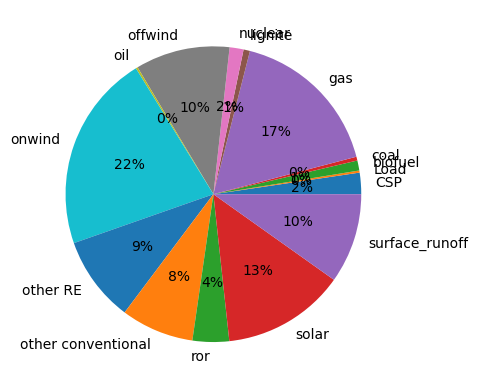

In [77]:
plt.pie(gen_p_by_carrier_pypsa.sum(), labels=gen_p_by_carrier_pypsa.columns, autopct='%.0f%%')
plt.show()

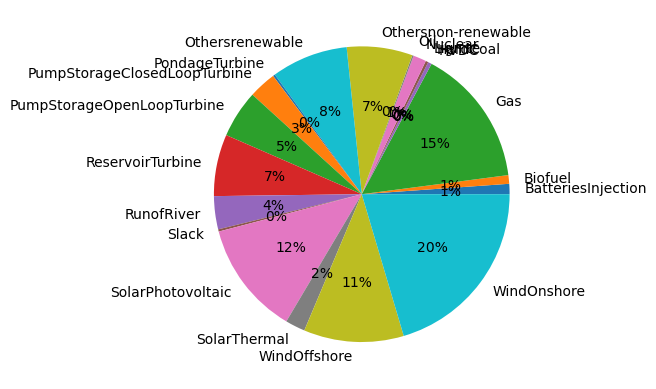

In [78]:
data = gen_p_by_carrier_remix.sum()
plt.pie(data[data>0], labels=data.index[data>0], autopct='%.0f%%')
plt.show()

In [79]:
gen_p_by_carrier_remix['Lignite'].sum()

12300871.55342

In [82]:
gen_p_by_carrier_pypsa['lignite'].sum() / gen_p_by_carrier_remix['Lignite'].sum()

2.293584105216918

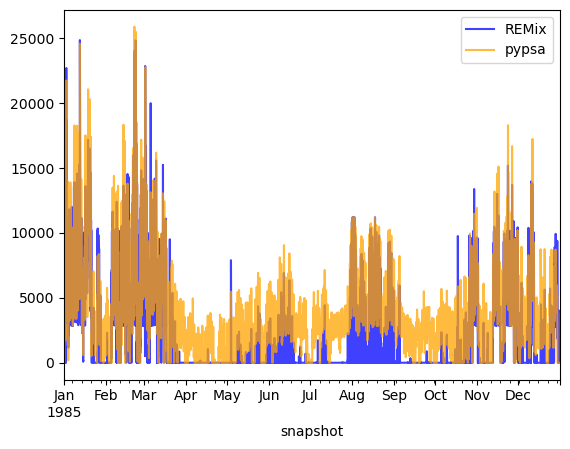

In [81]:
gen_p_by_carrier_remix['Lignite'].plot(label='REMix', alpha=0.75, c='blue', legend=False)
gen_p_by_carrier_pypsa['lignite'].plot(label='pypsa', alpha=0.75, c='orange', legend=False)
#plt.twinx()
#network.generators_t.p_max_pu['DE onwind'].plot(c='green')
plt.legend()
#plt.xlim('2000-05-15 00:00:00', '2000-05-16 23:00:00')

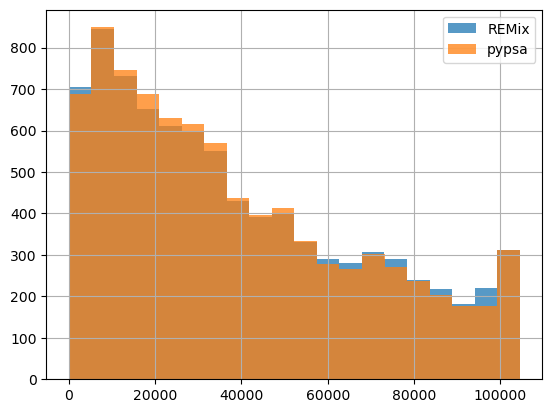

In [59]:
gen_p_remix['DE']['WindOnshore'].hist(label='REMix', alpha=0.75, bins=20)
gen_p_pypsa['DE']['onwind'].hist(label='pypsa', alpha=0.75, bins=20)
plt.legend()

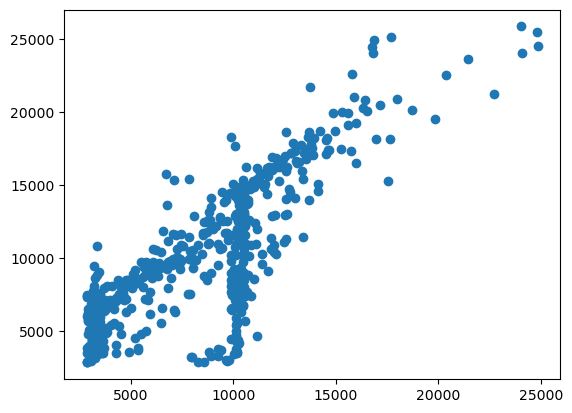

In [83]:
slack_hours = gen_p_remix.index[gen_p_remix['DE']['Slack'].round(1)>0]

plt.scatter(gen_p_by_carrier_remix['Lignite'][slack_hours].round(2), gen_p_by_carrier_pypsa['lignite'][slack_hours].round(2))

In [84]:
len(slack_pypsa.index[slack_pypsa.round(2)>0])

564

In [85]:
len(slack_remix.index[slack_remix.round(2)>0])

670

<Axes: xlabel='snapshot'>

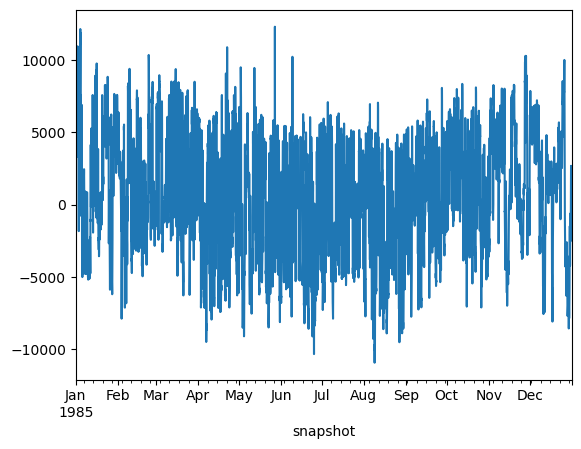

In [94]:
gen_p_remix['AT']['HVAC'].plot()

<Axes: xlabel='snapshot'>

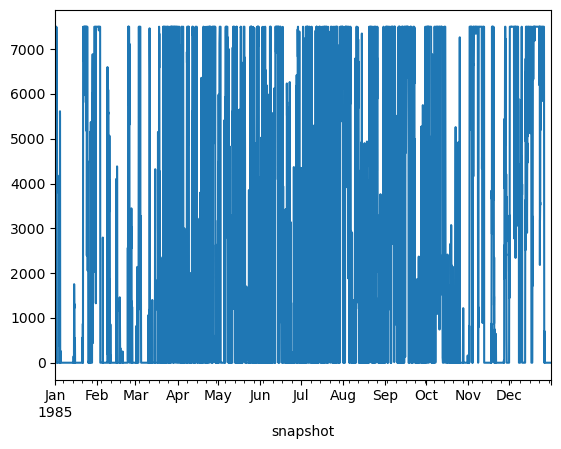

In [93]:
network.links_t.p0['DE00-AT00 HVAC'].plot()